<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.73 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 13:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 14.6 MB/s 
     |████████████████████████████████| 170 kB 60.7 MB/s 
     |████████████████████████████████| 133 kB 64.2 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 138 kB 55.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: u9zmpmdf
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/u9zmpmdf


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8pt27ozc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 15s 119ms/step - loss: 0.2223 - mean_squared_error: 0.2223 - mean_absolute_error: 0.4124 - val_loss: 0.1339 - val_mean_squared_error: 0.1339 - val_mean_absolute_error: 0.3157
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1665 - mean_squared_error: 0.1665 - mean_absolute_error: 0.3462 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2250
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1012 - mean_squared_error: 0.1012 - mean_absolute_error: 0.2584 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1510
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0552 - mean_squared_error: 0.0552 - mean_absolute_error: 0.1928 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1466
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0439 - mean_squared_error: 0.0439 

epoch,49
loss,0.00328
mean_squared_error,0.00328
mean_absolute_error,0.04656
val_loss,0.0135
val_mean_squared_error,0.0135
val_mean_absolute_error,0.08539
_runtime,28
_timestamp,1627048770
_step,49
best_val_loss,0.0135


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f6zaunwf with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 0.3076 - mean_squared_error: 0.3076 - mean_absolute_error: 0.4080 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1522
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1592 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1333
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1435 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0889
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0831 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0591
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_squared_

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,58
loss,0.04716
mean_squared_error,0.04716
mean_absolute_error,0.16936
val_loss,0.01711
val_mean_squared_error,0.01711
val_mean_absolute_error,0.1071
_runtime,17
_timestamp,1627048797
_step,58
best_val_loss,0.00284


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂
mean_squared_error,▃▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂
mean_absolute_error,▅▂▂▁▃▁▁▁▁▁▁▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃
val_loss,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
val_mean_squared_error,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
val_mean_absolute_error,▂▂▂▂▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4e8u2l3p with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.9593 - mean_squared_error: 0.9593 - mean_absolute_error: 0.7581 - val_loss: 0.2111 - val_mean_squared_error: 0.2111 - val_mean_absolute_error: 0.4396
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1256 - mean_squared_error: 0.1256 - mean_absolute_error: 0.3214 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1880
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1178 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1317
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1162 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1381
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0094 - mean_squared_error: 0.009

epoch,43
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01922
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.03645
_runtime,12
_timestamp,1627048824
_step,43
best_val_loss,0.00277


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dpguunmb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 2.5547 - mean_squared_error: 2.5547 - mean_absolute_error: 1.0853 - val_loss: 0.7359 - val_mean_squared_error: 0.7359 - val_mean_absolute_error: 0.8287
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.3139 - mean_squared_error: 0.3139 - mean_absolute_error: 0.4495 - val_loss: 0.2615 - val_mean_squared_error: 0.2615 - val_mean_absolute_error: 0.4778
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1725 - mean_squared_error: 0.1725 - mean_absolute_error: 0.3414 - val_loss: 0.1971 - val_mean_squared_error: 0.1971 - val_mean_absolute_error: 0.4067
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - mean_absolute_error: 0.2401 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - val_mean_absolute_error: 0.2271
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0675 - mean_squared_

epoch,42
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02489
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.04352
_runtime,15
_timestamp,1627048850
_step,42
best_val_loss,0.00287


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▁▁▁▁▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▁▁▁▁▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: csy7vusx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 82ms/step - loss: 1.0805 - mean_squared_error: 1.0805 - mean_absolute_error: 0.8415 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2694
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.2569 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0744
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0863 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1254
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0564 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0655
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0

epoch,57
loss,0.00474
mean_squared_error,0.00474
mean_absolute_error,0.05594
val_loss,0.00558
val_mean_squared_error,0.00558
val_mean_absolute_error,0.05282
_runtime,13
_timestamp,1627048875
_step,57
best_val_loss,0.00219


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁
val_loss,█▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▁
val_mean_squared_error,█▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▁
val_mean_absolute_error,█▂▄▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▄▂▂
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0n5yhgne with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 0.5346 - mean_squared_error: 0.5346 - mean_absolute_error: 0.6175 - val_loss: 0.0778 - val_mean_squared_error: 0.0778 - val_mean_absolute_error: 0.2191
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - mean_absolute_error: 0.2450 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1149
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - val_loss: 0.1091 - val_mean_squared_error: 0.1091 - val_mean_absolute_error: 0.3083
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.2156 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1645
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0221 - mean_squared_error: 0.0221 -

epoch,39
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.03263
val_loss,0.00669
val_mean_squared_error,0.00669
val_mean_absolute_error,0.06487
_runtime,12
_timestamp,1627048898
_step,39
best_val_loss,0.00453


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▃▂▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▃▂▁▁▁▁
mean_absolute_error,█▄▃▄▃▂▂▂▂▂▂▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▆▅▄▄▂▁▁▁
val_loss,▅▂▇▃▂▂▂▂▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂█▂▂▁▁▁▁
val_mean_squared_error,▅▂▇▃▂▂▂▂▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂█▂▂▁▁▁▁
val_mean_absolute_error,▅▃▇▄▃▃▃▂▂▂▅▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃█▃▃▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1ag7i46f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 46ms/step - loss: 0.8589 - mean_squared_error: 0.8589 - mean_absolute_error: 0.5301 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1100
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1283 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1341
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0988 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1729
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1033 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1739
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0160 - mean_squared_error

epoch,23
loss,0.05329
mean_squared_error,0.05329
mean_absolute_error,0.19442
val_loss,0.03583
val_mean_squared_error,0.03583
val_mean_absolute_error,0.1492
_runtime,11
_timestamp,1627048920
_step,23
best_val_loss,0.00532


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂
mean_absolute_error,█▃▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▅▄▄▄▄▄
val_loss,▃▃▅▄▃▂▃▁▄▂▁▁▁▁▃▁▂▁█▇▄▄▄▄
val_mean_squared_error,▃▃▅▄▃▂▃▁▄▂▁▁▁▁▃▁▂▁█▇▄▄▄▄
val_mean_absolute_error,▃▄▆▆▄▂▅▂▅▃▂▂▂▁▃▁▃▁█▇▅▅▅▅
_runtime,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: ya1ihk89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 28ms/step - loss: 0.1042 - mean_squared_error: 0.1042 - mean_absolute_error: 0.2349 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1366
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0560 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1485
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0613
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0423 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0561
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_e

epoch,51
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.0215
val_loss,0.00313
val_mean_squared_error,0.00313
val_mean_absolute_error,0.03825
_runtime,25
_timestamp,1627048961
_step,51
best_val_loss,0.00311


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁
val_loss,▇█▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▇█▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇█▃▂▂▂▂▃▂▁▂▃▂▁▁▂▂▁▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▃▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ajr3y2hn with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 93ms/step - loss: 0.1628 - mean_squared_error: 0.1628 - mean_absolute_error: 0.3402 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1308
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1125
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0666 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0900
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0691 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0956
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063 -

epoch,49
loss,0.0009
mean_squared_error,0.0009
mean_absolute_error,0.02327
val_loss,0.00539
val_mean_squared_error,0.00539
val_mean_absolute_error,0.04898
_runtime,14
_timestamp,1627048986
_step,49
best_val_loss,0.00539


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_loss,█▇▆▅▆▆▅▇▄▃▄▃▂▄▃▂▄▂▁▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▂▂▁▁
val_mean_squared_error,█▇▆▅▆▆▅▇▄▃▄▃▂▄▃▂▄▂▁▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▂▂▁▁
val_mean_absolute_error,█▆▅▅▆▇▆▇▅▄▅▃▃▅▄▃▃▂▂▂▃▃▃▁▂▁▁▂▃▂▂▁▂▂▁▂▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1cb0edjz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - mean_absolute_error: 0.3082 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1101
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0860 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0899
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0744 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1059
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1102 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0826
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0098 - mean_squared_error: 0.0

epoch,64
loss,0.00438
mean_squared_error,0.00438
mean_absolute_error,0.0549
val_loss,0.00746
val_mean_squared_error,0.00746
val_mean_absolute_error,0.06207
_runtime,13
_timestamp,1627049010
_step,64
best_val_loss,0.00541


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅██▅▄▅▄▅▃▂▂▅▄▃▃▃▂▂▃▄▁▂▂▁▁▁▃▁▂▁▂▁▂▂▂▃▂▂
val_mean_squared_error,▆▅▅██▅▄▅▄▅▃▂▂▅▄▃▃▃▂▂▃▄▁▂▂▁▁▁▃▁▂▁▂▁▂▂▂▃▂▂
val_mean_absolute_error,█▆▅▇▇▄▄▅▄▄▃▂▃▅▄▃▃▃▂▁▃▄▁▂▂▁▁▁▃▁▂▁▃▁▂▃▂▄▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: byd9yerd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 92ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - mean_absolute_error: 0.2691 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1118
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0831 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1204
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0634 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1446
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0784 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1269
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 -

epoch,49
loss,0.00342
mean_squared_error,0.00342
mean_absolute_error,0.04781
val_loss,0.00598
val_mean_squared_error,0.00598
val_mean_absolute_error,0.04899
_runtime,13
_timestamp,1627049034
_step,49
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▂▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁
val_loss,▅▆█▆▇▄▅▅▄▄▄▅▃▃▂▂▂▂▂▃▁▂▁▁▃▂▂▂▁▁▁▂▁▁▁▂▁▂▁▁
val_mean_squared_error,▅▆█▆▇▄▅▅▄▄▄▅▃▃▂▂▂▂▂▃▁▂▁▁▃▂▂▂▁▁▁▂▁▁▁▂▁▂▁▁
val_mean_absolute_error,▆▆█▇▇▅▆▆▅▅▅▅▃▄▂▂▂▂▂▂▁▁▁▁▃▂▂▂▁▁▁▂▁▁▁▂▁▂▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6btvyoj2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 6522.2921 - mean_squared_error: 6522.2921 - mean_absolute_error: 42.7036 - val_loss: 34.3451 - val_mean_squared_error: 34.3451 - val_mean_absolute_error: 5.6176
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 26.7272 - mean_squared_error: 26.7272 - mean_absolute_error: 4.3603 - val_loss: 49.4729 - val_mean_squared_error: 49.4729 - val_mean_absolute_error: 6.5529
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 1232.8934 - mean_squared_error: 1232.8934 - mean_absolute_error: 13.8397 - val_loss: 0.9837 - val_mean_squared_error: 0.9837 - val_mean_absolute_error: 0.9088
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 12.6984 - mean_squared_error: 12.6984 - mean_absolute_error: 2.7925 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_mean_absolute_error: 0.2877
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 20.8

epoch,20
loss,18.68161
mean_squared_error,18.68161
mean_absolute_error,2.5138
val_loss,0.04909
val_mean_squared_error,0.04909
val_mean_absolute_error,0.1929
_runtime,12
_timestamp,1627049056
_step,20
best_val_loss,0.02123


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▄▁▁▂▁▁▇▁▂▁▆▁▁▁▁▃▁▁▁
mean_squared_error,█▁▄▁▁▂▁▁▇▁▂▁▆▁▁▁▁▃▁▁▁
mean_absolute_error,█▂▆▂▂▃▂▁▆▂▄▂▅▁▂▂▁▅▂▂▂
val_loss,▅▇▁▁▃▁▁▁▁▆▁▂▁▁▅▁▁█▁▁▁
val_mean_squared_error,▅▇▁▁▃▁▁▁▁▆▁▂▁▁▅▁▁█▁▁▁
val_mean_absolute_error,▆▇▂▁▅▂▂▁▁▇▁▄▁▂▆▁▂█▁▁▁
_runtime,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: r92bs7z0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 146.9075 - mean_squared_error: 146.9075 - mean_absolute_error: 8.2356 - val_loss: 3.2617 - val_mean_squared_error: 3.2617 - val_mean_absolute_error: 1.6923
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 41.0425 - mean_squared_error: 41.0425 - mean_absolute_error: 5.0452 - val_loss: 11.5094 - val_mean_squared_error: 11.5094 - val_mean_absolute_error: 3.3673
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 26.4803 - mean_squared_error: 26.4803 - mean_absolute_error: 4.1786 - val_loss: 4.2728 - val_mean_squared_error: 4.2728 - val_mean_absolute_error: 2.0450
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 10.1582 - mean_squared_error: 10.1582 - mean_absolute_error: 2.7162 - val_loss: 7.0158 - val_mean_squared_error: 7.0158 - val_mean_absolute_error: 2.6372
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 12.0308 - mean_

epoch,48
loss,0.00435
mean_squared_error,0.00435
mean_absolute_error,0.04302
val_loss,0.00449
val_mean_squared_error,0.00449
val_mean_absolute_error,0.04987
_runtime,24
_timestamp,1627049091
_step,48
best_val_loss,0.00355


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▄▅▄▆▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▄▅▄▆▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▅▆▅▇▅▂▃▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ivy9e7jm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 35ms/step - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2842 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1434
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1418 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1200
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0614 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0914
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1004
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_erro

epoch,99
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01913
val_loss,0.0027
val_mean_squared_error,0.0027
val_mean_absolute_error,0.0355
_runtime,33
_timestamp,1627049136
_step,99
best_val_loss,0.0027


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s6mrpnbx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 27ms/step - loss: 0.7785 - mean_squared_error: 0.7785 - mean_absolute_error: 0.6877 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1638
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0881 - mean_squared_error: 0.0881 - mean_absolute_error: 0.2228 - val_loss: 0.1031 - val_mean_squared_error: 0.1031 - val_mean_absolute_error: 0.2951
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - mean_absolute_error: 0.2175 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0588
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0648
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_squared_error

epoch,33
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02514
val_loss,0.00331
val_mean_squared_error,0.00331
val_mean_absolute_error,0.038
_runtime,19
_timestamp,1627049180
_step,33
best_val_loss,0.00246


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
mean_absolute_error,▅▂▂▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁▁▁
val_loss,▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
val_mean_squared_error,▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
val_mean_absolute_error,▂▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yyv5esvf with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 44ms/step - loss: 5464.2313 - mean_squared_error: 5464.2313 - mean_absolute_error: 46.0689 - val_loss: 1.6619 - val_mean_squared_error: 1.6619 - val_mean_absolute_error: 0.9087
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 2.0112 - mean_squared_error: 2.0112 - mean_absolute_error: 0.9239 - val_loss: 0.2230 - val_mean_squared_error: 0.2230 - val_mean_absolute_error: 0.3669
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 279.1727 - mean_squared_error: 279.1727 - mean_absolute_error: 8.6495 - val_loss: 1867.3997 - val_mean_squared_error: 1867.3997 - val_mean_absolute_error: 42.7476
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 423.7149 - mean_squared_error: 423.7149 - mean_absolute_error: 13.2416 - val_loss: 0.1419 - val_mean_squared_error: 0.1419 - val_mean_absolute_error: 0.3374
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 72.4118

epoch,22
loss,2579.85303
mean_squared_error,2579.85303
mean_absolute_error,21.50807
val_loss,0.43836
val_mean_squared_error,0.43836
val_mean_absolute_error,0.55944
_runtime,11
_timestamp,1627049208
_step,22
best_val_loss,0.0349


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▂▁▁▁▁▂▃▁▁▁▁▁▃▁▁▁▁▁▁▁▆
mean_squared_error,█▁▂▁▁▁▁▂▃▁▁▁▁▁▃▁▁▁▁▁▁▁▆
mean_absolute_error,█▁▅▂▃▃▁▃▄▂▃▁▁▁▅▂▂▂▂▁▁▁▅
val_loss,▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▄▁▃▁▁█▁▂▁▁▁▂▁▂▁▁▁▁▁▂▁
_runtime,▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: jyivcoo3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 0.1922 - mean_squared_error: 0.1922 - mean_absolute_error: 0.3782 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1914
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2204 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1547
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1700 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1595
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1700 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1549
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0378 - mean_squared_erro

epoch,99
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03728
val_loss,0.00916
val_mean_squared_error,0.00916
val_mean_absolute_error,0.06599
_runtime,32
_timestamp,1627049251
_step,99
best_val_loss,0.00916


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ytcmypbo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 187.3418 - mean_squared_error: 187.3418 - mean_absolute_error: 10.0615 - val_loss: 65.1005 - val_mean_squared_error: 65.1005 - val_mean_absolute_error: 8.0641
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 39.7351 - mean_squared_error: 39.7351 - mean_absolute_error: 5.7868 - val_loss: 9.4710 - val_mean_squared_error: 9.4710 - val_mean_absolute_error: 2.8283
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 29.8229 - mean_squared_error: 29.8229 - mean_absolute_error: 4.8215 - val_loss: 4.1453 - val_mean_squared_error: 4.1453 - val_mean_absolute_error: 1.9788
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 6.3258 - mean_squared_error: 6.3258 - mean_absolute_error: 2.3820 - val_loss: 5.7184 - val_mean_squared_error: 5.7184 - val_mean_absolute_error: 2.3794
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 3.6476 - mean_squared_error

epoch,16
loss,17.31028
mean_squared_error,17.31028
mean_absolute_error,3.7433
val_loss,2.60909
val_mean_squared_error,2.60909
val_mean_absolute_error,1.56491
_runtime,10
_timestamp,1627049273
_step,16
best_val_loss,0.47


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▄▃▂▂▂▃▁▁▁▁▁▁▁▁▂▃
val_loss,█▂▁▂▅▃▁▁▂▁▁▁▁▁▁▃▁
val_mean_squared_error,█▂▁▂▅▃▁▁▂▁▁▁▁▁▁▃▁
val_mean_absolute_error,█▃▂▃▅▄▁▂▂▁▁▁▁▁▂▅▂
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅██
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: a6mqvsco with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.2139 - mean_squared_error: 0.2139 - mean_absolute_error: 0.3853 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1126
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1011 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0851
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0637 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0836
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0556 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0689
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0

epoch,59
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02233
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.0391
_runtime,14
_timestamp,1627049299
_step,59
best_val_loss,0.00302


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▅▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▆▄▂▂▂▂▄▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c7vityrz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 0.2144 - mean_squared_error: 0.2144 - mean_absolute_error: 0.4038 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - val_mean_absolute_error: 0.3126
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1690 - mean_squared_error: 0.1690 - mean_absolute_error: 0.3501 - val_loss: 0.0822 - val_mean_squared_error: 0.0822 - val_mean_absolute_error: 0.2263
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1125 - mean_squared_error: 0.1125 - mean_absolute_error: 0.2734 - val_loss: 0.0492 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1662
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0718 - mean_squared_error: 0.0718 - mean_absolute_error: 0.2215 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1427
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0511 - mean_squared_err

epoch,99
loss,0.00331
mean_squared_error,0.00331
mean_absolute_error,0.04692
val_loss,0.0138
val_mean_squared_error,0.0138
val_mean_absolute_error,0.08439
_runtime,25
_timestamp,1627049337
_step,99
best_val_loss,0.01371


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r6mdk8m1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 0.7834 - mean_squared_error: 0.7834 - mean_absolute_error: 0.5795 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_mean_absolute_error: 0.2352
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - mean_absolute_error: 0.2172 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.2277
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1670 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0647
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0534 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0587
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_

epoch,79
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.0212
val_loss,0.00321
val_mean_squared_error,0.00321
val_mean_absolute_error,0.04117
_runtime,26
_timestamp,1627049377
_step,79
best_val_loss,0.00308


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▂▁▁▁▁▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▁▁▁▁▂▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 96ouwxf5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 28ms/step - loss: 127.2928 - mean_squared_error: 127.2928 - mean_absolute_error: 8.5297 - val_loss: 12.6518 - val_mean_squared_error: 12.6518 - val_mean_absolute_error: 3.5366
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 34.6206 - mean_squared_error: 34.6206 - mean_absolute_error: 5.1127 - val_loss: 27.1556 - val_mean_squared_error: 27.1556 - val_mean_absolute_error: 5.1922
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 33.3601 - mean_squared_error: 33.3601 - mean_absolute_error: 4.4956 - val_loss: 65.8226 - val_mean_squared_error: 65.8226 - val_mean_absolute_error: 8.0287
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 25.3252 - mean_squared_error: 25.3252 - mean_absolute_error: 3.9010 - val_loss: 3.6401 - val_mean_squared_error: 3.6401 - val_mean_absolute_error: 1.6190
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 14.7291 - m

epoch,17
loss,0.78161
mean_squared_error,0.78161
mean_absolute_error,0.64353
val_loss,0.44847
val_mean_squared_error,0.44847
val_mean_absolute_error,0.64515
_runtime,14
_timestamp,1627049404
_step,17
best_val_loss,0.27364


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,▂▄█▁▆▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▂▄█▁▆▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▄▅█▂▇▂▂▁▁▂▁▂▃▁▁▁▁▁
_runtime,▁▂▂▂▃▃▅▅▅▆▆▆▇▇▇███
_timestamp,▁▂▂▂▃▃▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: skwsi1yu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - mean_absolute_error: 0.2834 - val_loss: 0.0697 - val_mean_squared_error: 0.0697 - val_mean_absolute_error: 0.2054
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - mean_absolute_error: 0.2058 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1042
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1117 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1745
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1105 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1518
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0121 - mean_squared_

epoch,14
loss,0.00431
mean_squared_error,0.00431
mean_absolute_error,0.05345
val_loss,0.01043
val_mean_squared_error,0.01043
val_mean_absolute_error,0.08847
_runtime,13
_timestamp,1627049430
_step,14
best_val_loss,0.01032


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▂▂▂▁▂▂▂▁▁▁▁
val_loss,█▂▄▃▁▂▁▁▂▁▂▁▂▁▁
val_mean_squared_error,█▂▄▃▁▂▁▁▂▁▂▁▂▁▁
val_mean_absolute_error,█▃▆▅▁▃▁▂▃▃▃▂▃▃▂
_runtime,▁▁▃▃▃▃▅▅▅▅▅▆▆▆█
_timestamp,▁▁▃▃▃▃▅▅▅▅▅▆▆▆█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 5tkqzjn7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - mean_absolute_error: 0.2205 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0846
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0444 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0772
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0380 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0637
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0353 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0603
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_erro

epoch,99
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01933
val_loss,0.00262
val_mean_squared_error,0.00262
val_mean_absolute_error,0.03684
_runtime,32
_timestamp,1627049475
_step,99
best_val_loss,0.00259


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 48adzqvi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - mean_absolute_error: 0.3055 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.2112
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1122 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1425
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0888 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1230
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0799 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1331
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0078 - mean_squared_error: 0.0078 -

epoch,36
loss,0.00449
mean_squared_error,0.00449
mean_absolute_error,0.05501
val_loss,0.0085
val_mean_squared_error,0.0085
val_mean_absolute_error,0.07553
_runtime,12
_timestamp,1627049516
_step,36
best_val_loss,0.00712


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▂▂▁▁▂▂▁▂▂▁▂▂▂▁▂▁▂▂
val_loss,█▄▃▄▂▂▃▂▂▂▂▃▂▂▂▂▂▂▃▁▂▂▂▁▁▂▁▂▁▂▁▁▁▁▂▁▁
val_mean_squared_error,█▄▃▄▂▂▃▂▂▂▂▃▂▂▂▂▂▂▃▁▂▂▂▁▁▂▁▂▁▂▁▁▁▁▂▁▁
val_mean_absolute_error,█▅▄▄▃▂▂▂▂▂▁▃▂▁▁▃▂▃▄▂▂▃▃▁▂▃▁▃▂▂▂▂▂▂▃▂▂
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 79ma31c4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 4.8505 - mean_squared_error: 4.8505 - mean_absolute_error: 0.9575 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0919
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1146 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1009
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1198 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1303
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1233 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1050
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0319 - mean_squared_erro

epoch,25
loss,0.0045
mean_squared_error,0.0045
mean_absolute_error,0.05446
val_loss,0.00937
val_mean_squared_error,0.00937
val_mean_absolute_error,0.08067
_runtime,15
_timestamp,1627049544
_step,25
best_val_loss,0.00516


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▆▃▄█▂▂▃▂▄▂▁▁▃▁▁▂▂▁▂▂▄▁▁▂
val_mean_squared_error,▃▄▆▃▄█▂▂▃▂▄▂▁▁▃▁▁▂▂▁▂▂▄▁▁▂
val_mean_absolute_error,▃▄▅▄▃█▃▁▄▃▅▃▁▁▄▁▁▃▃▂▂▂▄▂▂▃
_runtime,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: rtusvc3v with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 44ms/step - loss: 126.7612 - mean_squared_error: 126.7612 - mean_absolute_error: 9.0701 - val_loss: 7.7412 - val_mean_squared_error: 7.7412 - val_mean_absolute_error: 2.6565
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 49.7776 - mean_squared_error: 49.7776 - mean_absolute_error: 5.7736 - val_loss: 53.4172 - val_mean_squared_error: 53.4172 - val_mean_absolute_error: 6.7149
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 34.6254 - mean_squared_error: 34.6254 - mean_absolute_error: 4.9505 - val_loss: 9.4829 - val_mean_squared_error: 9.4829 - val_mean_absolute_error: 3.0532
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 22.9035 - mean_squared_error: 22.9035 - mean_absolute_error: 4.1958 - val_loss: 2.7373 - val_mean_squared_error: 2.7373 - val_mean_absolute_error: 1.5967
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 40.5996 - mean_

epoch,20
loss,2.25749
mean_squared_error,2.25749
mean_absolute_error,1.18635
val_loss,0.46576
val_mean_squared_error,0.46576
val_mean_absolute_error,0.65835
_runtime,14
_timestamp,1627049580
_step,20
best_val_loss,0.05163


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▄▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁
mean_squared_error,█▃▃▂▄▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁
mean_absolute_error,█▅▄▄▅▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,▂█▂▁▁▂▄▂▆▂▁▂▁▁▁▃▂▂▁▁▁
val_mean_squared_error,▂█▂▁▁▂▄▂▆▂▁▂▁▁▁▃▂▂▁▁▁
val_mean_absolute_error,▄█▄▃▂▃▆▃█▃▁▃▃▁▃▅▄▄▁▂▂
_runtime,▁▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
_timestamp,▁▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 6xe7rqma with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 47ms/step - loss: 0.1152 - mean_squared_error: 0.1152 - mean_absolute_error: 0.2697 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0916
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0894 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0818
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0581 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0796
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0778
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 

epoch,49
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.02056
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.03983
_runtime,17
_timestamp,1627049611
_step,49
best_val_loss,0.00278


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▄▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▁▁▁▁▁▂
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1vodt02w with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 44ms/step - loss: 0.1100 - mean_squared_error: 0.1100 - mean_absolute_error: 0.2406 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0810
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0602 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1393
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0731 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0960
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0394 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0591
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_squared_err

epoch,99
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.02047
val_loss,0.00313
val_mean_squared_error,0.00313
val_mean_absolute_error,0.04015
_runtime,24
_timestamp,1627049649
_step,99
best_val_loss,0.00313


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▃▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▃▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▄▂▂▂▃▂▂▄▂▁▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 47dzbhkv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 46ms/step - loss: 0.6320 - mean_squared_error: 0.6320 - mean_absolute_error: 0.4637 - val_loss: 0.2576 - val_mean_squared_error: 0.2576 - val_mean_absolute_error: 0.4936
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0838 - mean_squared_error: 0.0838 - mean_absolute_error: 0.2390 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0989
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0859 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0792
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1021 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0968
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0136 - mean_squared_error

epoch,49
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02794
val_loss,0.006
val_mean_squared_error,0.006
val_mean_absolute_error,0.05408
_runtime,19
_timestamp,1627049686
_step,49
best_val_loss,0.00437


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▂▁▁▁▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁
val_loss,█▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▃▂▃▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sti8uhmx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 31ms/step - loss: 163.6551 - mean_squared_error: 163.6551 - mean_absolute_error: 8.6674 - val_loss: 19.1587 - val_mean_squared_error: 19.1587 - val_mean_absolute_error: 4.2224
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 35.8045 - mean_squared_error: 35.8045 - mean_absolute_error: 4.5170 - val_loss: 60.3300 - val_mean_squared_error: 60.3300 - val_mean_absolute_error: 7.7650
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 29.5868 - mean_squared_error: 29.5868 - mean_absolute_error: 4.7222 - val_loss: 81.5261 - val_mean_squared_error: 81.5261 - val_mean_absolute_error: 9.0277
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 23.5409 - mean_squared_error: 23.5409 - mean_absolute_error: 3.8869 - val_loss: 11.1382 - val_mean_squared_error: 11.1382 - val_mean_absolute_error: 2.9242
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 20.6161 -

epoch,35
loss,1.11813
mean_squared_error,1.11813
mean_absolute_error,0.67223
val_loss,0.04121
val_mean_squared_error,0.04121
val_mean_absolute_error,0.17381
_runtime,23
_timestamp,1627049733
_step,35
best_val_loss,0.03571


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆█▂▃▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▆█▂▃▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▇█▃▄▆▁▁▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: traehtv1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 0.4655 - mean_squared_error: 0.4655 - mean_absolute_error: 0.4602 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2629
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1985 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1278
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0975 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1080
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0646 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0974
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0063 - mean_squared_

epoch,87
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02506
val_loss,0.00301
val_mean_squared_error,0.00301
val_mean_absolute_error,0.03861
_runtime,28
_timestamp,1627049774
_step,87
best_val_loss,0.00259


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▂▁▁▁▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂█▁▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▂█▁▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▃█▂▂▃▂▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cr1e3ext with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 45ms/step - loss: 1.7601 - mean_squared_error: 1.7601 - mean_absolute_error: 0.9761 - val_loss: 0.2695 - val_mean_squared_error: 0.2695 - val_mean_absolute_error: 0.4820
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - mean_absolute_error: 0.3160 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0799
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - mean_absolute_error: 0.2611 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - val_mean_absolute_error: 0.2540
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0880 - mean_squared_error: 0.0880 - mean_absolute_error: 0.2410 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1409
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0401 - mean_squared_error

epoch,24
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02758
val_loss,0.00468
val_mean_squared_error,0.00468
val_mean_absolute_error,0.05055
_runtime,14
_timestamp,1627049820
_step,24
best_val_loss,0.00407


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▃▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▃▁▁▁▁
mean_absolute_error,█▄▄▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▆▆▅▂▁▁▁
val_loss,▄▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▁▁▁▁▁
val_mean_squared_error,▄▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▁▁▁▁▁
val_mean_absolute_error,▅▁▃▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▇█▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: y8sdz14r with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 150ms/step - loss: 0.1589 - mean_squared_error: 0.1589 - mean_absolute_error: 0.3246 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1022
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0807 - val_loss: 0.0507 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.2083
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1127 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1194
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0785 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1082
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043 

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02832
val_loss,0.00621
val_mean_squared_error,0.00621
val_mean_absolute_error,0.0624
_runtime,17
_timestamp,1627049852
_step,49
best_val_loss,0.00469


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▂▂▁▂▁▁▁▂▂▁▁
val_loss,▃█▃▃▂▂▂▃▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▃▃▂▂▂▃▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▄▄▂▂▃▄▄▃▂▃▂▂▂▂▂▂▂▂▃▁▁▄▂▁▁▁▂▂▁▂▂▁▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xtdh6k0p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 28ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1539 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0822
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0708 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0983
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0498 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1143
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0697 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0556
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error

epoch,49
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.03265
val_loss,0.00375
val_mean_squared_error,0.00375
val_mean_absolute_error,0.04147
_runtime,27
_timestamp,1627049894
_step,49
best_val_loss,0.00327


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▃▁▂▂▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▃▁▂▂▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▄▂▃▃▂▂▂▂▂▂▃▃▂▃▁▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▂▁▂▂
val_loss,▆▇█▃▅▂▂▂▃▂▃▂▄▃▂▂▂▂▂▁▁▁▁▂▁▁▁▂▄▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▆▇█▃▅▂▂▂▃▂▃▂▄▃▂▂▂▂▂▁▁▁▁▂▁▁▁▂▄▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▅▇█▃▆▂▃▃▄▂▃▂▅▃▂▂▂▂▃▁▁▁▁▂▁▂▂▂▅▁▁▂▂▂▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jfj5tmvj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627049920
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▁▁████
_timestamp,▁▁▁▁▁▁████
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 445ursll with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 47ms/step - loss: 0.1652 - mean_squared_error: 0.1652 - mean_absolute_error: 0.3325 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1287
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0618 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1036
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0602 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0972
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1105
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error

epoch,49
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02938
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.04149
_runtime,20
_timestamp,1627049955
_step,49
best_val_loss,0.00374


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▃▃▄▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▃▃▄▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▇▄▃▄▂▃▄▂▂▂▂▂▂▂▂▃▂▂▁▂▄▂▁▁▁▁▂▂▂▁▁▂▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6w6kwu3m with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 47ms/step - loss: 0.3773 - mean_squared_error: 0.3773 - mean_absolute_error: 0.4492 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1792
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1413 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0941
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0853 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.2027
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1335 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0519
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_

epoch,81
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02246
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.03568
_runtime,41
_timestamp,1627050012
_step,81
best_val_loss,0.00251


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▄▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▄▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▄▁▁▄▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kpfhlbs5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - mean_absolute_error: 0.2080 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0749
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0521 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0648
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0624
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0431 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0697
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0020 - mean_squared_error

epoch,49
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02267
val_loss,0.00302
val_mean_squared_error,0.00302
val_mean_absolute_error,0.036
_runtime,29
_timestamp,1627050064
_step,49
best_val_loss,0.00292


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▁▂▃▂▁▂▂▂▂▂▁▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▆▃▃▆▃▄▂▂▂▃▂▂▃▂▂▃▂▂▂▃▂▂▁▂▁▂▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,█▆▅▅▆▃▃▆▃▄▂▂▂▃▂▂▃▂▂▃▂▂▂▃▂▂▁▂▁▂▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,▇▆▅▇█▄▄█▄▄▃▂▂▃▂▂▅▂▂▅▃▃▃▃▃▂▁▂▁▃▁▁▁▂▁▂▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vd2usjj9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 19374.0571 - mean_squared_error: 19374.0571 - mean_absolute_error: 84.9247 - val_loss: 1414.6554 - val_mean_squared_error: 1414.6554 - val_mean_absolute_error: 37.0318
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 568.8553 - mean_squared_error: 568.8553 - mean_absolute_error: 16.9869 - val_loss: 4.7952 - val_mean_squared_error: 4.7952 - val_mean_absolute_error: 2.0304
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 5.7654 - mean_squared_error: 5.7654 - mean_absolute_error: 1.9622 - val_loss: 0.7973 - val_mean_squared_error: 0.7973 - val_mean_absolute_error: 0.7032
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 1.0149 - mean_squared_error: 1.0149 - mean_absolute_error: 0.7553 - val_loss: 0.4069 - val_mean_squared_error: 0.4069 - val_mean_absolute_error: 0.4218
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2403 - mean_sq

epoch,17
loss,264.79645
mean_squared_error,264.79645
mean_absolute_error,12.03318
val_loss,1682.14453
val_mean_squared_error,1682.14453
val_mean_absolute_error,41.01324
_runtime,11
_timestamp,1627050088
_step,17
best_val_loss,0.11053


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▂
val_loss,▇▁▁▁▁▆▁▁▁▁▁▁▁▆▁▁▁█
val_mean_squared_error,▇▁▁▁▁▆▁▁▁▁▁▁▁▆▁▁▁█
val_mean_absolute_error,▇▁▁▁▁▆▁▁▃▃▁▁▂▇▂▁▂█
_runtime,▁▁▁▅▅▅▅▅▅▅▅███████
_timestamp,▁▁▁▅▅▅▅▅▅▅▅███████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 766q0pvt with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 25ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1258 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0713
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0372 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0595
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0319 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0479
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0302 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0466
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.

epoch,49
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.02034
val_loss,0.00266
val_mean_squared_error,0.00266
val_mean_absolute_error,0.03601
_runtime,22
_timestamp,1627050127
_step,49
best_val_loss,0.00266


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: r47u2gs1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 28ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error:

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,11
_timestamp,1627050153
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅███
_timestamp,▁▁▁▅▅▅▅███
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: z8qsg80m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 28ms/step - loss: 0.1104 - mean_squared_error: 0.1104 - mean_absolute_error: 0.2420 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0872
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0587 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0729
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0794
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0468 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0841
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_

epoch,87
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01775
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.03527
_runtime,43
_timestamp,1627050214
_step,87
best_val_loss,0.00243


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▂▃▂▂▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁
val_mean_squared_error,█▆▄▄▄▂▃▂▂▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁
val_mean_absolute_error,█▇▄▆▅▂▄▃▂▄▄▂▂▂▃▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▃▁▂▂▂▂▅▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aie32fzd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 80ms/step - loss: 0.1189 - mean_squared_error: 0.1189 - mean_absolute_error: 0.2834 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1216
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1355 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1712
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0889 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0820
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0702 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0922
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 -

epoch,49
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02942
val_loss,0.00371
val_mean_squared_error,0.00371
val_mean_absolute_error,0.04576
_runtime,16
_timestamp,1627050245
_step,49
best_val_loss,0.00331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▄▃▂▂▂▂▂▂▂▁▂▁▃▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a77nwyl1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 2s 5ms/step - loss: 0.0640
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 9.6356e-04
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 8.5987e-04
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 8.7402e-04
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 7.9728e-04
Epoch 11/100
39/39 [==============================] - 0s 5ms/step - loss: 5.7496e-04
Epoch 12/100
39/39 [==============================] - 0s 5ms/step - loss: 6.3044e-04
Epoch 13/100


In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

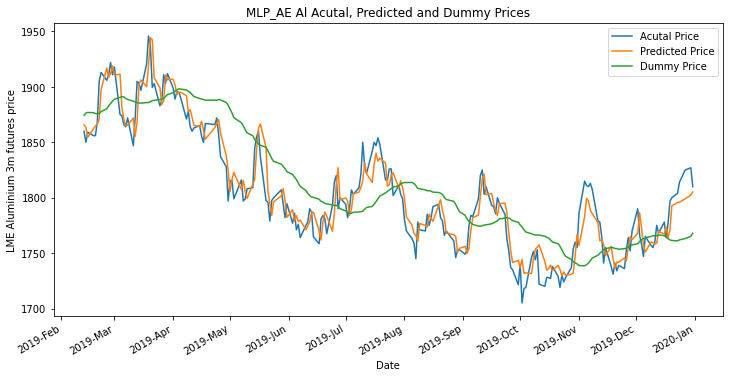

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

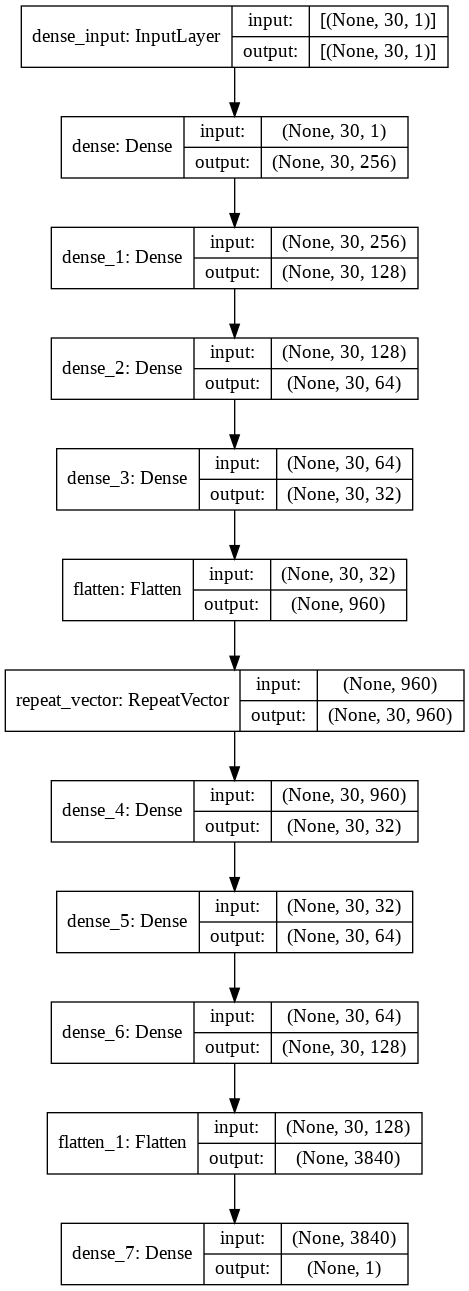

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0039560808830239646
RMSE:  0.06289738375341192
MAE:  0.05035467728621137
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Al/assets
